In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras import regularizers

In [12]:
# Hyperparameters
epochs = 100
batch_train_size = 16
batch_size = 15
initial_learning_rate = 1.5e-4
l2_regularize = 1.5e-5
l1_regularize = 1e-6

# Directories
root = 'C:/Users/kahny/ML Model'
train_dir = os.path.join(root, 'Train_Resized/')
val_dir = os.path.join(root, 'Validate_Resized/')
test_dir = os.path.join(root, 'Test_Resized/')

In [13]:
# Function to create data generators
def image_gen_w_aug(train_parent_directory, validate_parent_directory, test_parent_directory):
    # Data augmentation for the training data
    train_datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=35,
        zoom_range=0.3,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescaling for validation and test data
    val_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)

    # Data generators
    train_generator = train_datagen.flow_from_directory(
        train_parent_directory,
        target_size=(75, 75),
        batch_size=batch_train_size,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_directory(
        validate_parent_directory,
        target_size=(75, 75),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_parent_directory,
        target_size=(75, 75),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# Create data generators
train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, val_dir, test_dir)

# Function to build the model which attempts to simulate the InceptionV3 layers without using Transfer Learning.
def build_sequential_inception(input_shape):
    model = Sequential()

    # Initial Conv Layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # First Inception-like block
    model.add(Conv2D(32, (1, 1), padding='same', activation='relu'))
    model.add(Conv2D(48, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Second Inception-like block
    model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
    model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third Inception-like block
    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(192, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Fourth Inception-like block
    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(192, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(BatchNormalization())
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_regularize, l2=l2_regularize)))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_regularize, l2=l2_regularize)))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for classification

    return model

# Initialize model
input_shape = (75, 75, 3)
model = build_sequential_inception(input_shape)

# Custom Callback to stop training when both training and validation accuracy reach 97%
class CustomStopper(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and val_acc is not None:
            if train_acc >= 0.97 and val_acc >= 0.97:
                print("Stopping training as both training and validation accuracy have reached 97%.")
                self.model.stop_training = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
custom_stopper = CustomStopper()

# Function to convert DirectoryIterator to tf.data.Dataset
def generator_to_dataset(generator):
    output_signature = (
        tf.TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
    def generator_function():
        for batch in generator:
            yield batch
    return tf.data.Dataset.from_generator(generator_function, output_signature=output_signature)

# Convert the generators to tf.data.Dataset
train_dataset = generator_to_dataset(train_generator).repeat()
validation_dataset = generator_to_dataset(validation_generator).repeat()

# Print model summary
model.summary()

# Train the model
with tf.device("/GPU:0"):
    history = model.fit(
        train_dataset,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_dataset,
        validation_steps=len(validation_generator),
        callbacks=[reduce_lr, custom_stopper]
    )

# Save the model
model.save('my_model.h5')

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

# Print summary
print(f"\nModel Summary:")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Test Loss: {test_loss:.4f}\n")
print(f"Learning Rate: {initial_learning_rate}")
print(f"Epochs: {epochs}")
print(f"Steps Per Epoch: {len(train_generator)}")
print(f"Batch Size: {train_generator.batch_size}")

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_65 (Conv2D)              │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 37, 37, 32)     │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 37, 37, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 37, 37, 64)     │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 18, 18, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 18, 18, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 18, 18, 128)    │       307,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 9, 9, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 9, 9, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 4, 4, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 4, 4, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 2, 2, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,89

 Total params: 2,256,179 (8.61 MB)

 Trainable params: 2,255,731 (8.60 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.4968 - loss: 0.9939 - val_accuracy: 0.3433 - val_loss: 1.1055 - learning_rate: 1.5000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7593 - loss: 0.6456 - val_accuracy: 0.5967 - val_loss: 0.9871 - learning_rate: 1.5000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7831 - loss: 0.5460 - val_accuracy: 0.7967 - val_loss: 0.6361 - learning_rate: 1.5000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8409 - loss: 0.4462 - val_accuracy: 0.9267 - val_loss: 0.3079 - learning_rate: 1.5000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8525 - loss: 0.3944 - val_accuracy: 0.8767 - val_loss: 0.3199 - learning_rate: 1.5000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8722 - loss: 0.3645 - val_accuracy: 0.9333 - val_loss: 0.1884 - learning_rate: 1.5000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/st

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9857 - loss: 0.0653

Model Summary:
Training Accuracy: 0.9704
Validation Accuracy: 0.9700
Test Accuracy: 0.9800

Training Loss: 0.1059
Validation Loss: 0.0971
Test Loss: 0.0677

Learning Rate: 0.00015
Epochs: 100
Steps Per Epoch: 150
Batch Size: 16


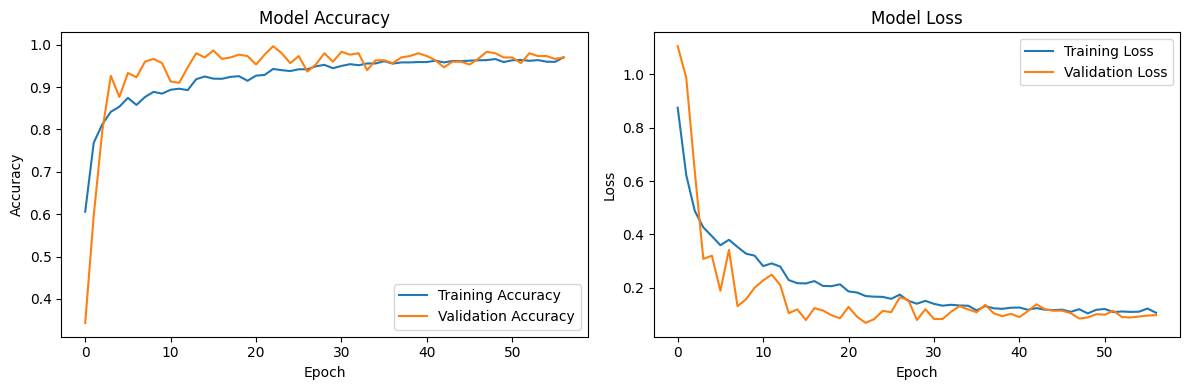

In [14]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()